In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import string
import numpy as np
import math
import matplotlib.pyplot as plt
import time
# start = time.time()

In [2]:
def sigmoid_array(x):
    # input: array
    # output: sigmoid applied to each value of input array
    return 1 / (1 + np.exp(-x))

def softmax(x):
    # input: array
    # output: softmax of array
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x))


def define_alphabet():
    # creates list of alphabet to use when parsing text data
    base_en = 'abcdefghijklmnopqrstuvwxyz'
    special_chars = ' !?¿¡' + string.punctuation + string.digits
    italian = 'àèéìíòóùúã'
    french = 'àâæçéèêêîïôœùûüÿ'
    all_lang_chars = base_en + italian + french 
    small_chars = list(set(list(all_lang_chars)))
    small_chars.sort() 
    big_chars = list(set(list(all_lang_chars.upper())))
    big_chars.sort()
    small_chars += special_chars
    letters_string = ''
    letters = small_chars + big_chars
    for letter in letters:
        letters_string += letter
    return small_chars,big_chars,letters_string

alphabet, _, _ = define_alphabet()
print(alphabet, len(alphabet))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ã', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'î', 'ï', 'ò', 'ó', 'ô', 'ù', 'ú', 'û', 'ü', 'ÿ', 'œ', ' ', '!', '?', '¿', '¡', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] 94


In [3]:
# fits labelBinarizer obj to alphabet so it can make one-hot encoding
# c = unique characters between eng, fre, ital = 93
# le = LabelBinarizer()
# le.fit(alphabet)


In [4]:
txt = ' '
with open("languageIdentification.data/train", 'r') as f:
    txt += f.read()
# with open("languageIdentification.data/dev", 'r') as f:
#     txt += f.read()
# with open("languageIdentification.data/test", 'r',encoding = 'latin-1') as f:
#     txt += f.read()
alphab = list(set(list(txt.lower())))
input_dim = (len(alphab) + 1) * 5
# print(len(alphab), input_dim)

In [5]:
le = LabelBinarizer()
le.fit(alphab)


LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [6]:
def seq_chars(s, num_chars=5):
    # input: string, s
    # output: list of 5 sequential characters of string from beginning to end
    n = len(s)
    return [s[i:(i+num_chars)] for i in range(n-4)]

def binarize(seq_str):
    # input: sequence of characters
    # output: concatenated one hot encoding of each character
        # w/ dimension (5c, 1)
    arr = []
    if len(seq_str) == 0:
        return np.zeros(shape = (1,input_dim))
    for char in seq_str[0]:
        # if character not in training data add 1 to 'other' category
        if char not in alphab:
            arr.append(np.append(le.transform([char])[0], 1))
        else:
            arr.append(np.append(le.transform([char])[0], 0))
    return np.concatenate([np.array(i) for i in arr]).reshape(1, input_dim)



In [7]:
# if youve not seen a char before, it's all zeros.. this may be the runtime error
# binarize(seq_chars('ㄱㄱabㄱ')).shape
# arr = []
# for char in 'ㄱㄱabㄱ':
#     if char not in alphab:
#         arr.append(np.append(le.transform([char])[0], 1))
#     else:
#         arr.append(np.append(le.transform([char])[0], 0))
# # [len(i) for i in arr]
# np.concatenate([np.array(i) for i in arr]).reshape(1,input_dim).shape

## Backprop functions

$\nabla_{y} L = y - \hat{y}$

In [8]:
def grad_l_wrt_y(y_pred, y_test):
    return y_pred - y_test #(3,1)


$\nabla_{b^{2}} L = \nabla_{y^{'}}L = \sum_{i} \frac{\delta{L}}{\delta{y_{i}}} y_{i}(\delta{ij} - y_{j}) = \sum_{i} (y_{i} - \hat{y_{i}}) y_{i}(\delta_{ij} - y_{j})$

In [9]:
def grad_l_wrt_b2(y_pred, y_test):
    vec = []
    # for each yj
    for j, val in enumerate(list(y_pred)):
        counter = 0
        # go over all values in yi
        for i, val2 in enumerate(list(y_pred)):
            if i == j:
                counter += (y_pred[i] - y_test[i])*(y_pred[i])*(1-y_pred[j])
            else:
                counter += (y_pred[i] - y_test[i])*(y_pred[i])*(-y_pred[j])
        vec.append(counter)
    return np.array(vec)

     
  

$\nabla_{w^{2}} L = \nabla_{y^{'}}L h^{T} = \nabla_{b^{2}}L h^{T}$

In [10]:
def grad_l_wrt_w2(grad_b2, hidden_layer):
    # take grad wrt b^2 and mult by hidden layer
    return grad_b2.dot(hidden_layer.T) #(3,1)*(1,d) is (3,d)



$\nabla_{h}L = W^{2T} \nabla_{y^{'}}L = W^{2T} \nabla_{b^{2}}L$

In [11]:
def grad_l_wrt_h(grad_b2, W2):
    return np.dot(W2.T, grad_b2) #(d,3)*(3,1) is (d,1)


$\frac{\delta{L}}{\delta{h^{'}_{i}}} = \frac{\delta{L}}{\delta{h_{i}}} h_{i}(1-h_{i})$ ie multiply each elt in $\nabla_{h}L$ by $h_{i}(1-h_{i})$

In [12]:
def grad_l_wrt_h_tilde(grad_h, h_layer):
    # does element wise multiplication
    return grad_h * ((h_layer) * (1-h_layer)) # (d,1)(element mult)(d,1) is (d,1)

#     vec = []
#     for i in range(len(h_layer)):
# #         print("mult:", grad_h[i], (h_layer[i] * (1-h_layer[i])))
#         vec.append(grad_h[i] * (h_layer[i] * (1-h_layer[i])))

#     return np.array(vec)



$\nabla_{w^{1}} L = (\nabla_{h^{'}}L)(x^{T})$

In [13]:
def grad_l_wrt_w1(grad_h_tilde, input_x):
    return np.dot(grad_h_tilde, input_x) #(d,1)*(1,5c) is (d,5c)



$\nabla_{b^{1}} L = (\nabla_{h^{'}}L)$

In [14]:
def grad_l_wrt_b1(grad_h_tilde):
    return grad_h_tilde

In [15]:
def create_input_matrix(filename):
    with open(filename, 'r') as handle:
        y_final = []
#         final_mat = np.zeros(shape=(1,input_dim))
        final_mat = []
        for line in handle: # for each line
            y_test = []


            s = line.split()
            label = s[0] # Eng, ital, or french
            sentence = ' '.join(s[1:]).lower() # rest of sentence

            # create (n, 5c) matrix. Each row is a (1, 5c) one hot encoding vector
            # n is number of 5 seq characters in the sentence
            encode_mat = binarize(seq_chars(sentence))
#             final_mat = np.vstack([final_mat, encode_mat])
            final_mat.append(encode_mat)
            # accumulate pred for each (1,5c) vector
            pred = np.zeros(3)

            # create arbitrary label for each language
            # as long as you're consistent



            # for each 5 character encoder vector
            for row in range(len(encode_mat)):
                    # get that row
                if label == "ENGLISH":
                    y_test.append(1)
                elif label == "ITALIAN":
                    y_test.append(2)
                else:
                    y_test.append(3)
            y_final.append(y_test)
#     final_mat = np.delete(final_mat, (0), axis=0)
    fin = np.vstack(final_mat)
    fin_lab = np.concatenate([np.array(i) for i in y_final])
    fin_fin = np.hstack([fin, fin_lab.reshape(len(fin_lab),1)])
    return fin_fin

In [16]:
# mat, lab = create_input_matrix(filename = "languageIdentification.data/tiny_train")
# fin = np.vstack(mat)
# fin_lab = np.concatenate([np.array(i) for i in lab])
# tiny_train_mat = np.hstack([fin, fin_lab.reshape(len(fin_lab),1)])



In [17]:
# import time
# start = time.time()
# mat, lab = create_input_matrix(filename = "languageIdentification.data/train")
# end = time.time()
# print(end-start)
# takes about 5.5 minutes

In [18]:
# print(tiny_train_mat.shape)
# print(len(mat), len(lab))

In [19]:
# train_mat = create_input_matrix(filename = "languageIdentification.data/train")

# fin = np.vstack(mat)
# fin_lab = np.concatenate([np.array(i) for i in lab])

# fin_fin = np.hstack([fin, fin_lab.reshape(len(fin_lab),1)])

In [20]:
# fin_fin.shape

In [21]:
def forward(x, W1, bias1, W2, bias2):
    # input: 
        #(5c,1) input vector
        # (d,5c) weight matrix W1
        # (d,1) bias vector
        # (3,d) weight matrix W2
        # (3,1) bias vector
    # output:
        # (d, 1) hidden layer
        # (3, 1) predicted vector, y
    hidden_layer = sigmoid_array(np.dot(W1, x.T) + bias1)
    y = softmax(np.dot(W2, hidden_layer) + bias2)
    return hidden_layer, y


def backprop(y_pred, y_test, h_layer, input_x, W1, bias1, W2, bias2, eta=.1):   
    # input: ingredients for calculating gradients
    # output: W1, bias1, W2, bias2 after backprop
    
    grad_l_y = grad_l_wrt_y(y_pred, y_test)
#     print('grad_l_y shape is {}'.format(grad_l_y.shape))
#     print(grad_l_y)

    grad_l_b2 = grad_l_wrt_b2(y_pred, y_test)
#     print(grad_l_b2)
#     print('grad_l_b2 shape is {}'.format(grad_l_b2.shape))

    grad_l_w2 = grad_l_wrt_w2(grad_l_b2, h_layer)
#     print(grad_l_w2)
#     print('grad_l_w2 shape is {}'.format(grad_l_w2.shape))

    grad_l_h = grad_l_wrt_h(grad_l_b2, W2)
#     print(grad_l_h)
#     print('grad_l_h shape is {}'.format(grad_l_h.shape))

    grad_h_tilde = grad_l_wrt_h_tilde(grad_l_h, h_layer)
#     print(grad_h_tilde)
#     print('grad_h_tilde shape is {}'.format(grad_h_tilde.shape))

    grad_l_w1 = grad_l_wrt_w1(grad_h_tilde, input_x)
#     print(grad_l_w1)
#     print('grad_l_w1 shape is {}'.format(grad_l_w1.shape))

    grad_l_b1 = grad_l_wrt_b1(grad_h_tilde)
#     print(grad_l_b1)
#     print('grad_l_b1 shape is {}'.format(grad_l_b1.shape))

    W1 = W1 - eta * grad_l_w1
    W2 = W2 - eta * grad_l_w2
    bias2 = bias2 - eta * grad_l_b2
    bias1 = bias1 - eta * grad_l_b1

    return W1, bias1, W2, bias2



In [22]:
def train_nn(train_data, W1, bias1, W2, bias2):
    
    train_labels = train_data[:,-1]
    train_data = np.delete(train_data, (-1), axis=1)

    # for each 5 character encoder vector
    for ind in range(len(train_data)):
        # create arbitrary label for each language
        if train_labels[ind] == 1: # english
            y_test = np.array([0,1,0])
        elif train_labels[ind] == 2: # italian
            y_test = np.array([1,0,0])
        else:
            y_test = np.array([0,0,1])


        # get that row
        input_x = train_data[ind, :].reshape(1,input_dim)
        
        # forward prop
        h_layer, y_pred = forward(input_x, W1, bias1, W2, bias2)
        # backwards prop
        W1, bias1, W2, bias2 = backprop(y_pred.reshape(3,1), y_test, h_layer, 
                                        input_x, W1, bias1, W2, bias2, eta=eta)

    return W1, bias1, W2, bias2

In [23]:
def test_nn(filename, W1, bias1, W2, bias2, file2=None):
    loss_li = []
    counter = 0
    code = 'utf-8'
    # if testing on test set
    if file2 is not None:
        code = 'latin-1'
        with open(file2, 'r') as f:
            lines = f.read().lower().splitlines()

    with open(filename, 'r', encoding=code) as handle:
        num_chances = 0 # number of lines in text file
        num_correct = 0 
        for line in handle: # for each line
            num_chances += 1
            if line.split()[0] in ['ENGLISH', 'ITALIAN', 'FRENCH']:
                # make sure to do a try except for this for the testing file
                s = line.split()
                label = s[0].lower() # Eng, ital, or french
                sentence = ' '.join(s[1:]).lower() # rest of sentence
            else:
                sentence = line.lower()
                label = lines[counter]
                counter += 1

            # create (n, 5c) matrix. Each row is a (1, 5c) one hot encoding vector
            # n is number of 5 seq characters in the sentence
            encode_mat = binarize(seq_chars(sentence))

            # accumulate pred for each (1,5c) vector
            pred = np.zeros(3)

            # create arbitrary label for each language
            # as long as you're consistent
            if "english" in label:
                y_test = np.array([0,1,0])
            elif 'italian' in label:
                y_test = np.array([1,0,0])
            else:
                y_test = np.array([0,0,1])

            num_rows = 0

            # for each 5 character encoder vector
            for row in range(len(encode_mat)):
                # get that row
                input_x = encode_mat[row,:].reshape(1,input_dim)
                num_rows += 1

                # forward prop
                h_layer, y_pred = forward(input_x, W1, bias1, W2, bias2)
                # accumulate softmax
                pred += y_pred.reshape(3,)

            # AFTER a single sentence/row is done
            pred_avg = pred / num_rows  # avg prediction over all 5 character sequences
            loss = np.square(pred_avg - y_test).sum()# calculate loss over pred_avg
            loss_li.append(loss)
            pred_final = np.zeros(3)
            # get index of max probability of pred_avg to make final prediction
            pred_final[np.argmax(pred_avg)] = 1

            if np.all(pred_final - y_test == np.array([0,0,0])):
                num_correct += 1

    # after going through all lines
    accuracy = num_correct / num_chances
    return accuracy, loss_li



In [24]:
np.random.seed(1)
d = 100
eta = 0.1

W1 = np.random.uniform(size=(d, input_dim))
bias1 = np.random.uniform(size=[d,1])
W2 = np.random.uniform(size=(3,d))
bias2 = np.random.uniform(size=[3, 1])
eta = 0.1

teeny_mat = create_input_matrix(filename = "languageIdentification.data/teeny_tiny_train.txt")
# np.random.shuffle(teeny_mat)
loss_accum = []
# print(teeny_mat.shape)


In [25]:
for i in range(350):
    np.random.shuffle(teeny_mat)
    W1, bias1, W2, bias2 = train_nn(teeny_mat, W1, bias1, W2, bias2)
    accuracy, loss_li = test_nn("languageIdentification.data/teeny_tiny_train.txt", W1, bias1, W2, bias2)
#     print(accuracy)
#     plt.plot(np.array(loss_li))
#     plt.show()
    loss_accum.append(loss_li[0])


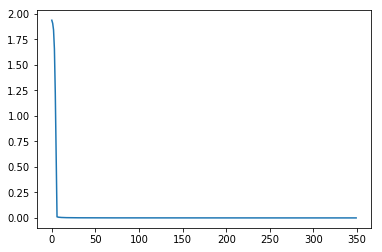

In [26]:
plt.plot(loss_accum)
plt.show()


## part A

In [59]:
d, eta = 100, .1


W1 = np.random.uniform(size=(d, input_dim))
bias1 = np.random.uniform(size=[d,1])
W2 = np.random.uniform(size=(3,d))
bias2 = np.random.uniform(size=[3, 1])
eta = 0.1
tiny_train_mat = create_input_matrix(filename = "languageIdentification.data/tiny_train")
# end1 = time.time()


acc_li_train = []
acc_li_dev = []
loss_acum = []
# train 3 times
for i in range(3):
    # get test before training, and after each train
    accuracy_t, _ = test_nn("languageIdentification.data/tiny_train", W1, bias1, W2, bias2)
    accuracy_d, loss_li = test_nn("languageIdentification.data/dev", W1, bias1, W2, bias2)


    acc_li_train.append(accuracy_t)
    acc_li_dev.append(accuracy_d)
    loss_accum.append(loss_li)
    # train
    np.random.shuffle(tiny_train_mat)
    W1, bias1, W2, bias2 = train_nn(tiny_train_mat, W1, bias1, W2, bias2)




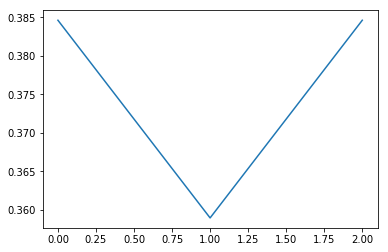

[0.38461538461538464, 0.358974358974359, 0.38461538461538464]

In [60]:
plt.plot(acc_li_train)
plt.show()
acc_li_train

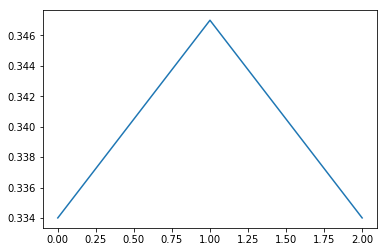

[0.334, 0.347, 0.334]

In [62]:
plt.plot(acc_li_dev)
plt.show()
acc_li_dev

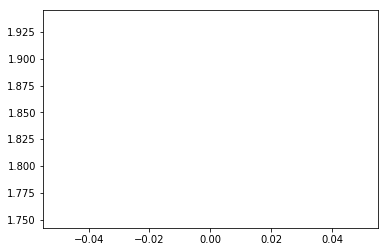

## part b

In [31]:
set1 = (50, .05)
set2 = (100, .05)
set3 = (50, .5)
set4 = (200, .5)
set5 = (25, .01)
list_params = [set1, set2, set3, set4, set5]
dict_params = {}

In [32]:
np.random.seed(1)
# tiny_train_mat = create_input_matrix(filename = "languageIdentification.data/tiny_train")


for params in list_params:
    d, eta = params

    W1 = np.random.uniform(size=(d, input_dim))
    bias1 = np.random.uniform(size=[d,1])
    W2 = np.random.uniform(size=(3,d))
    bias2 = np.random.uniform(size=[3, 1])
    eta = 0.1
    # end1 = time.time()


    acc_li_train = []
    acc_li_dev = []
    loss_acum = []
    # train 3 times
    for i in range(3):
        # get test before training, and after each train
#         accuracy_t, _ = test_nn("languageIdentification.data/tiny_train", W1, bias1, W2, bias2)
#         accuracy_d, loss_li = test_nn("languageIdentification.data/dev", W1, bias1, W2, bias2)


#         acc_li_train.append(accuracy_t)
#         acc_li_dev.append(accuracy_d)
#         loss_accum.append(loss_li)
        # train
        np.random.shuffle(tiny_train_mat)
        W1, bias1, W2, bias2 = train_nn(tiny_train_mat, W1, bias1, W2, bias2)
    
    # test on dev data after training 3 times
    accuracy_d, loss_li = test_nn("languageIdentification.data/dev", W1, bias1, W2, bias2)
    dict_params[params] = [accuracy_d, W1, bias1, W2, bias2]

In [33]:
list_keys = list(dict_params.keys())
best_so_far = list_keys[0]
for key in list_keys:
    if dict_params[best_so_far][0] < dict_params[key][0]:
        best_so_far = key
print(best_so_far)

(50, 0.05)


In [56]:
# i already have the w1, b1, etc for the best combo
W1_best, bias1_best, W2_best, bias2_best = dict_params[best_so_far][1:]
accuracy_test, loss_li = test_nn("languageIdentification.data/test", W1_best, bias1_best,
                                 W2_best, bias2_best, 'languageIdentification.data/test_solutions')

0.38333333333333336


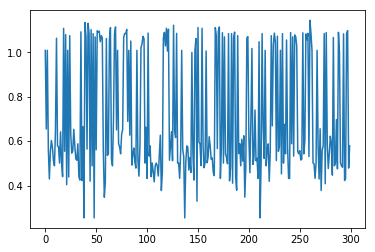

In [57]:
print(accuracy_test)
plt.plot(loss_li)
plt.show()

In [36]:
# print(acc_li_train)
# print(acc_li_dev)
# # plt.plot(np.array(loss_li))
# # plt.show()
# # print(sum(loss_li))

In [37]:
# print(bias2)
# W1, bias1, W2, bias2 = train_nn(tiny_train_mat, W1, bias1, W2, bias2)
# print(bias2)
# accuracy, loss_li = test_nn("languageIdentification.data/train", W1, bias1, W2, bias2)
# print(accuracy)
# plt.plot(np.array(loss_li))
# # plt.show()
# print(sum(loss_li))

In [38]:
# # dev testing
# accuracy, loss_li = test_nn("languageIdentification.data/dev", W1, bias1, W2, bias2)
# print(accuracy)
# plt.plot(np.array(loss_li))
# plt.show()
# print(sum(loss_li))

In [39]:
# np.random.shuffle(tiny_train_mat)

In [40]:
# print(bias2)
# W1, bias1, W2, bias2 = train_nn(tiny_train_mat, W1, bias1, W2, bias2)
# print(bias2)
# accuracy, loss_li = test_nn("languageIdentification.data/train", W1, bias1, W2, bias2)
# print(accuracy)
# plt.plot(np.array(loss_li))
# plt.show()
# print(sum(loss_li))

In [41]:
# # dev testing
# accuracy, loss_li = test_nn("languageIdentification.data/dev", W1, bias1, W2, bias2)
# print(accuracy)
# print(sum(loss_li))

In [42]:
# plt.plot(np.array(loss_li))
# plt.show()

In [43]:
# # test testing
# accuracy, loss_li = test_nn("languageIdentification.data/test", W1, bias1, 
#                             W2, bias2,"languageIdentification.data/test_solutions")
# print(accuracy)
# plt.plot(np.array(loss_li))
# plt.show()
# print(sum(loss_li))
# end2 = time.time()

In [44]:
# .46, .65, .81
# dev: .715

In [45]:
# .49, .73, .51
# dev: .571

In [46]:
# 2315 / 60

In [47]:
# print("time to create train matrix", end1-start)
# print('time to finish all training and testing', end2-start) # 40 minutes

In [48]:
# np.random.seed(1)
# d = 100
# eta = 0.1

# W1 = np.random.uniform(size=(3, input_dim))
# bias1 = np.random.uniform(size=[3,1])
# W2 = np.random.uniform(size=(3,3))
# bias2 = np.random.uniform(size=[3, 1])
# eta = 0.1

# teeny_mat = create_input_matrix(filename = "languageIdentification.data/teeny_tiny_train.txt")
# # np.random.shuffle(teeny_mat)

In [49]:
# accuracy, loss_li = test_nn("languageIdentification.data/teeny_tiny_train.txt", W1_new, bias1_new, W2_new, bias2_new)

In [50]:
# ex = teeny_mat[0,0:415]
# h_layer, y_pred = forward(ex, W1, bias1, W2, bias2)
# print(h_layer, y_pred.sum())

In [51]:
# # h_layer works
# a = np.dot(ex, W1.T) + bias1
# for val in a:
#     print(1/(1+np.exp(-val)))

In [52]:
# b = np.dot(W2, h_layer) + bias2

In [53]:
# # y_pred works
# print(np.exp(b) / np.exp(b).sum())
# print(y_pred)

In [54]:
# W1_new